In [1]:
import deepxde as dde
from deepxde.backend import torch
import matplotlib.pyplot  as plt
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
def VGM(psi, theta_r, theta_s, alpha, K_s):
    """
    this function calculates volumetric water content and hydraulic conductivity
    from matric potential (psi: negative) given VGM (van-Genuchen and Mualem model) parameters
    output: (theta, K)
    theta: volumetric water content
    K: hydraulic conductivity
    By default, alpha, n, and K_s are the parameters to be estiated.
    """
    l = 0.5
    n = 10.4

    m = 1 - 1/n
    S_e = (1 + (-alpha*psi)**n)**(-m)
    theta =  S_e * (theta_s - theta_r) + theta_r
    K = K_s*S_e**l*(1-(1-S_e**(1/m))**m)**2
    return theta, K
# parameter values
alpha = dde.Variable(0.1) #0.79# /cm
K_s = dde.Variable(1.08) #1.08 cm/hour
theta_s = dde.Variable(0.1) #0.25
theta_r = dde.Variable(0.153)
L_star = dde.Variable(10.0) # cm

In [3]:


def pde(x,y):
    psi = y[:,0:1]
    theta = y[:,1:2]
    K = y[:,2:3]
    theta_t = dde.grad.jacobian(y,x,i=1,j=1)
    psi_z = dde.grad.jacobian(y,x,i=0,j=0)
    psi_zz = dde.grad.hessian(y,x,component=0,i=0,j=0)
    K_z = dde.grad.jacobian(y,x,i=2,j=0)

    residual = theta_t - K_z*psi_z - K*psi_zz - K_z
    l = 0.5
    n = 10.4

    m = 1 - 1/n
    S_e = (1 + (-alpha*psi)**n)**(-m)
    vg_theta =  S_e * (theta_s - theta_r) + theta_r
    vg_k = K_s*S_e**l*(1-(1-S_e**(1/m))**m)**2

    residual_1 = K - vg_k
    residual_2 = theta - vg_theta
    #print(residual)
    return [residual,residual_1,residual_2]  

In [4]:
class Outputifier:
    def __init__(self, f1,f2,f3):
        self.f1 = f1
        self.f2 = f2
        self.f3 = f3

    def __call__(self, x,y):
        psi = self.f1(y[:,0:1])
        theta = self.f2(y[:,1:2])
        K = self.f3(y[:,2:3])

        return torch.hstack((psi,theta,K))

# Example
out_transform_org = Outputifier(lambda x: -torch.exp(x), torch.sigmoid, torch.exp)
out_transform = Outputifier(lambda x: -torch.abs(x), torch.sigmoid, torch.abs)

out_transform2 = Outputifier(lambda x: -torch.pow(x,2), torch.sigmoid, torch.exp)
def output_transform(x,y):
    psi = -torch.exp(y[:,0:1])
    theta = torch.sigmoid(y[:,1:2])
    K = torch.exp(y[:,2:3])

    return torch.hstack((psi,theta,K))

Text(0.5, 0, '$\\psi$ [m]')

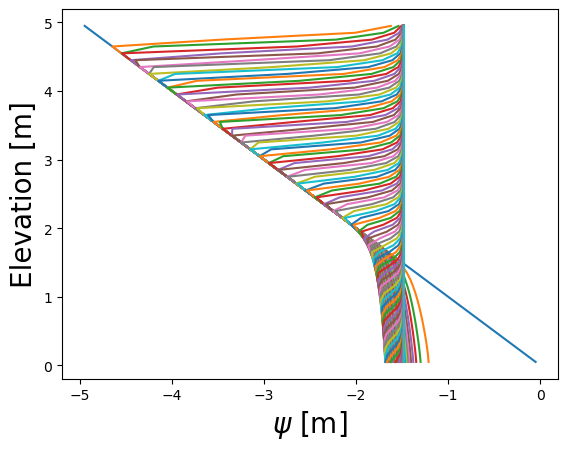

In [5]:
dz=0.1
ProfileDepth=5.0
z=np.arange(dz/2.0,ProfileDepth,dz)
n=z.size

# Grid in time
t = np.linspace(0,10,101)




psi = np.load("test1112_HSS.npy")


for i in range(0,t.size-1):
    #plt.subplot(121)
    plt.plot(psi[i,:],z)
    #plt.subplot(122)
    #plt.plot(theta[i,:],z)

#pl.subplot(121)
plt.ylabel('Elevation [m]',fontsize=20)
plt.xlabel(r'$\psi$ [m]',fontsize=20)
#pl.subplot(122)#
#pl.xlabel(r'$\theta$ [-]',fontsize=20)


In [6]:
Dataset = []
for i,time_step in enumerate(t):
    for j,k in enumerate(z):
        Dataset.append([k,time_step,psi[i][j]])

Dataset = np.array(Dataset)

In [7]:
X_train = Dataset[:,0:2]
U_train = Dataset[:,2:3]

In [8]:
geom = dde.geometry.Interval(0, 5)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [9]:
observe_y = dde.icbc.PointSetBC(X_train, U_train,component=0)

In [10]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [observe_y],
    num_domain=100,
    num_boundary=100,
    num_initial=100,
    anchors=X_train,
)

In [11]:
#import itertools

#combs = itertools.combinations_with_replacement([torch.exp, torch.sigmoid, torch.tanh], 3)
#for c in combs:
#    out_transform = Outputifier(lambda x: -torch.exp(x), torch.sigmoid, torch.exp)

#print(list(combs))

In [12]:
layer_size = [2] + [128] * 8 + [3]
activation = "swish"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
net.apply_output_transform(out_transform_org)
model = dde.Model(data, net)


In [13]:
# callbacks for storing results
fnamevar = "variables_test0302.dat"
variable = dde.callbacks.VariableValue([alpha,theta_s,K_s], period=1000, filename=fnamevar)

# Compile, train and save model
model.compile("adam", lr=1e-5,external_trainable_variables=[alpha,theta_s,K_s])
loss_history, train_state = model.train(
    iterations=20000 ,display_every=1000,callbacks=[variable]
)




Compiling model...
'compile' took 0.000556 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.40e-08, 5.48e-03, 1.61e-01, 8.85e-01]    [7.40e-08, 5.48e-03, 1.61e-01, 8.85e-01]    []  
1000      [2.16e-03, 3.95e-02, 3.19e-02, 2.30e-01]    [2.16e-03, 3.95e-02, 3.19e-02, 2.30e-01]    []  
2000      [3.75e-03, 1.63e-02, 3.19e-03, 1.11e-01]    [3.75e-03, 1.63e-02, 3.19e-03, 1.11e-01]    []  
3000      [8.03e-03, 1.86e-02, 3.83e-03, 7.70e-02]    [8.03e-03, 1.86e-02, 3.83e-03, 7.70e-02]    []  
4000      [1.13e-02, 1.16e-02, 4.28e-03, 5.02e-02]    [1.13e-02, 1.16e-02, 4.28e-03, 5.02e-02]    []  
5000      [9.88e-03, 5.78e-03, 3.38e-03, 3.49e-02]    [9.88e-03, 5.78e-03, 3.38e-03, 3.49e-02]    []  
6000      [7.94e-03, 5.10e-03, 2.49e-03, 2.28e-02]    [7.94e-03, 5.10e-03, 2.49e-03, 2.28e-02]    []  
7000      [6.21e-03, 4.42e-03, 2.38e-03, 1.83e-02]    [6.21e-03, 4.42e-03, 2.38e-03, 1.83e-02]    []  
8

In [34]:
model.compile("adam", lr=1e-5)
loss_history, train_state = model.train(
    iterations=5000,display_every=1000
)

Compiling model...
'compile' took 0.002612 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
20000     [6.00e-04, 5.61e-04, 3.29e-04, 1.31e-03]    [6.00e-04, 5.61e-04, 3.29e-04, 1.31e-03]    []  
21000     [6.02e-04, 5.32e-04, 3.21e-04, 1.26e-03]    [6.02e-04, 5.32e-04, 3.21e-04, 1.26e-03]    []  
22000     [6.00e-04, 5.26e-04, 3.11e-04, 1.14e-03]    [6.00e-04, 5.26e-04, 3.11e-04, 1.14e-03]    []  
23000     [5.95e-04, 5.21e-04, 3.00e-04, 1.04e-03]    [5.95e-04, 5.21e-04, 3.00e-04, 1.04e-03]    []  
24000     [5.89e-04, 5.23e-04, 2.93e-04, 9.48e-04]    [5.89e-04, 5.23e-04, 2.93e-04, 9.48e-04]    []  
25000     [5.82e-04, 5.21e-04, 2.89e-04, 8.77e-04]    [5.82e-04, 5.21e-04, 2.89e-04, 8.77e-04]    []  

Best model at step 25000:
  train loss: 2.27e-03
  test loss: 2.27e-03
  test metric: []

'train' took 306.687042 s



In [14]:
Preds = model.predict(X_train)
theta,K = VGM(psi,0.153,0.25,0.79,1.08)
theta_preds,k_preds = VGM(Preds[:,0],0.154,0.26,0.79,1.08)

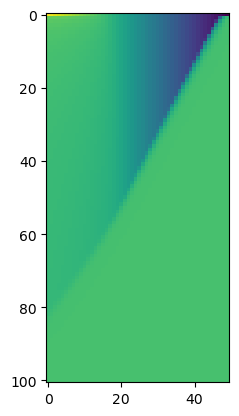

In [15]:
plt.imshow(psi)

Text(0.5, 0.98, 'PINN prediction for hydraulic pressure (psi)')

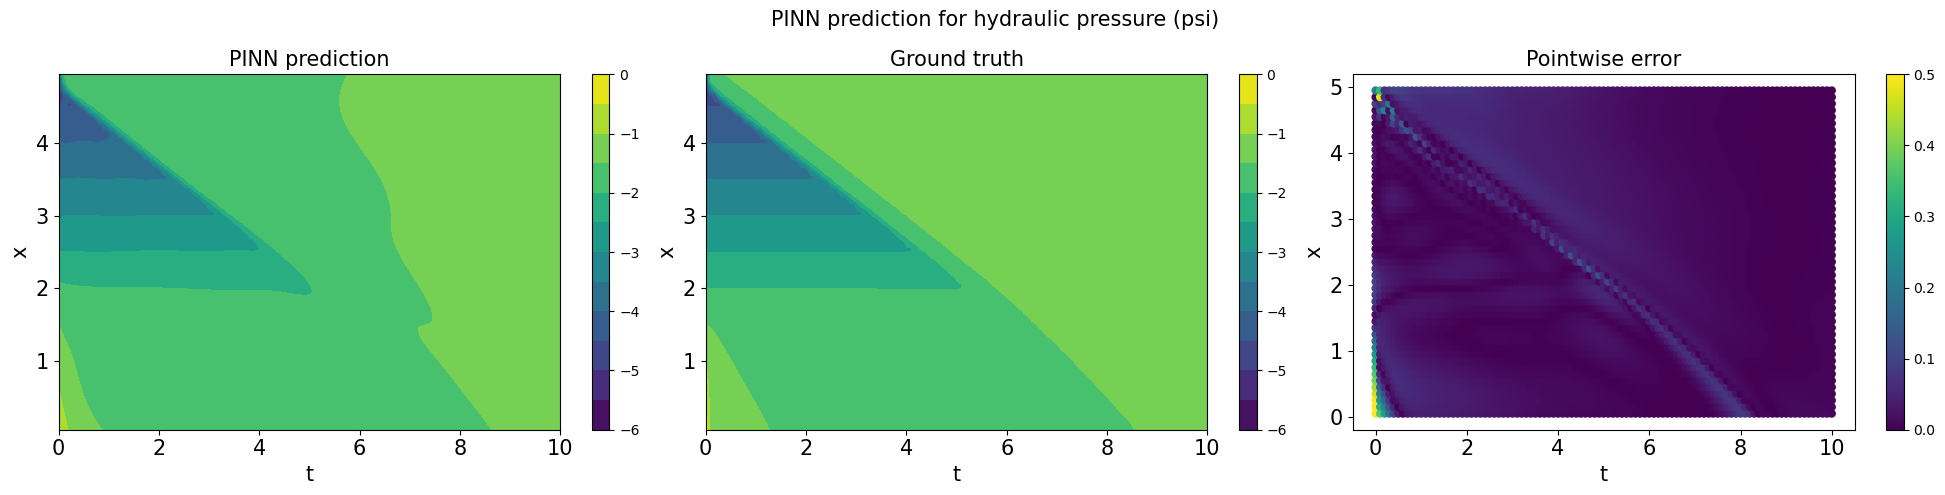

In [22]:
fig, ax = plt.subplots(1,3,figsize=(20,5),tight_layout=True)

im0=ax[0].contourf(X_train[:,1].reshape((101,50)),X_train[:,0].reshape((101,50)),Preds[:,0].reshape((101,50)),levels=[-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0],vmin=-6,vmax=0)

fig.colorbar(im0)

im1 = ax[1].contourf(X_train[:,1].reshape((101,50)),X_train[:,0].reshape((101,50)),psi,levels=[-6,-5.5,-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0],vmin=-6,vmax=0)
fig.colorbar(im1)

im2 = ax[2].scatter(X_train[:,1],X_train[:,0],c = np.abs((psi.reshape(5050)-Preds[:,0])),marker=".",s=100,vmin=0,vmax=0.5)
fig.colorbar(im2)


ax[0].set_title("PINN prediction",fontsize=15)
ax[0].set_xlabel("t",fontsize=15)
ax[0].set_ylabel("x",fontsize=15)

ax[1].set_title("Ground truth",fontsize=15)
ax[1].set_xlabel("t",fontsize=15)
ax[1].set_ylabel("x",fontsize=15)
ax[2].set_title("Pointwise error",fontsize=15)
ax[2].set_xlabel("t",fontsize=15)
ax[2].set_ylabel("x",fontsize=15)



ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)

fig.suptitle("PINN prediction for hydraulic pressure (psi)",fontsize=15)
#fig.savefig("vgpsi.pdf",dpi=500)

Text(0.5, 0.98, 'PINN prediction for volumetric water content (theta)')

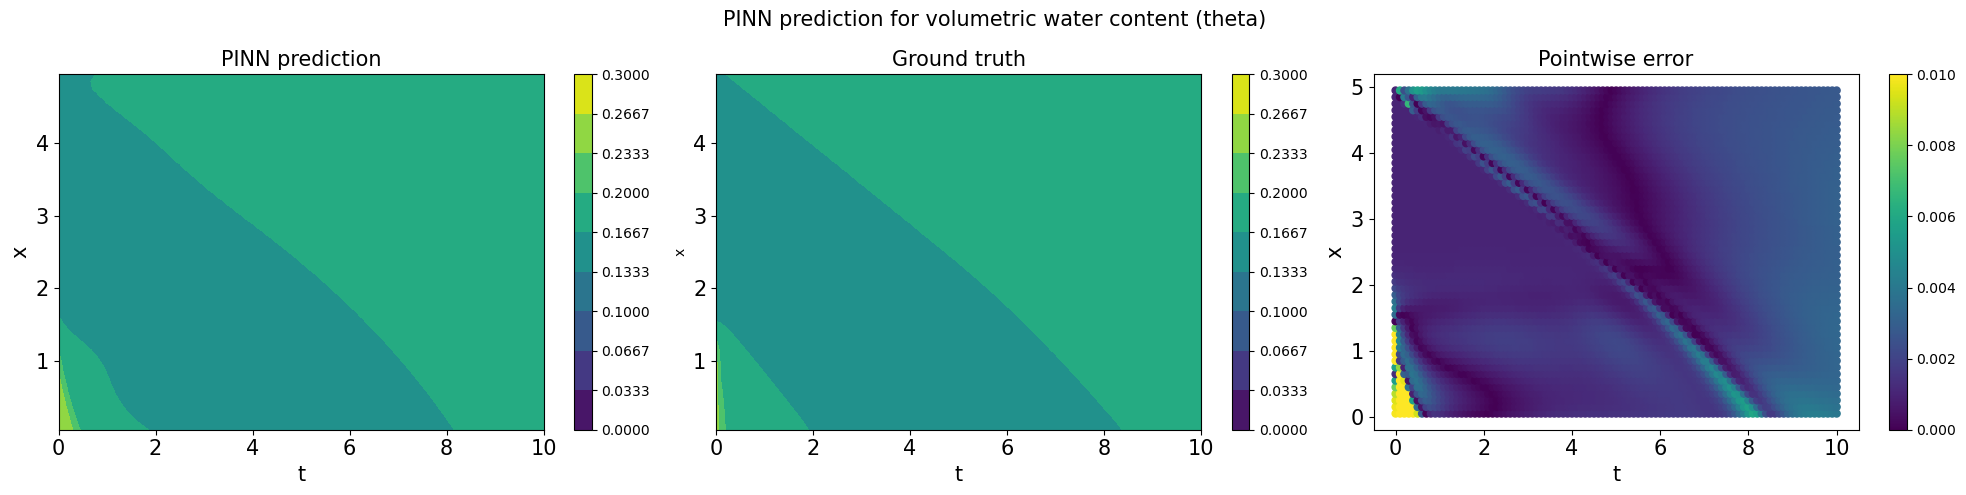

In [23]:
fig, ax = plt.subplots(1,3,figsize=(20,5),tight_layout=True)

im0=ax[0].contourf(X_train[:,1].reshape((101,50)),X_train[:,0].reshape((101,50)),theta_preds.reshape((101,50)),levels=np.linspace(0,0.3,10))

fig.colorbar(im0)

im1 = ax[1].contourf(X_train[:,1].reshape((101,50)),X_train[:,0].reshape((101,50)),theta,levels=np.linspace(0,0.3,10))
fig.colorbar(im1)

im2 = ax[2].scatter(X_train[:,1],X_train[:,0],c = np.abs((theta.reshape(5050)-theta_preds.reshape(5050))),marker=".",s=100,vmin=0,vmax=0.01)
fig.colorbar(im2)


ax[0].set_title("PINN prediction",fontsize=15)
ax[0].set_xlabel("t",fontsize=15)
ax[0].set_ylabel("x",fontsize=15)

ax[1].set_title("Ground truth",fontsize=15)
ax[1].set_xlabel("t",fontsize=15)
ax[1].set_ylabel("x")
ax[2].set_title("Pointwise error",fontsize=15)
ax[2].set_xlabel("t",fontsize=15)
ax[2].set_ylabel("x",fontsize=15)



ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)

fig.suptitle("PINN prediction for volumetric water content (theta)",fontsize=15)
#fig.savefig("vgtheta.pdf",dpi=500)

Text(0.5, 0.98, 'PINN prediction for hydraulic conductivity (K)')

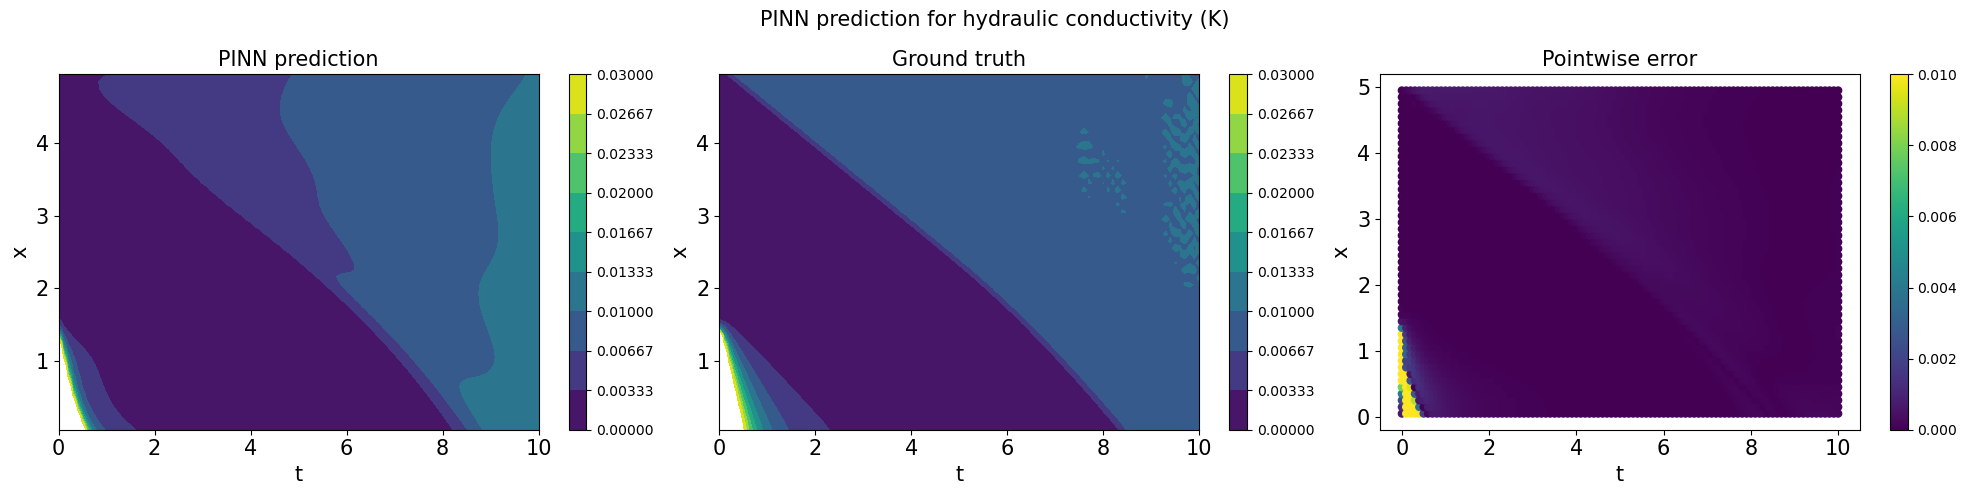

In [25]:
fig, ax = plt.subplots(1,3,figsize=(20,5),tight_layout=True)

im0=ax[0].contourf(X_train[:,1].reshape((101,50)),X_train[:,0].reshape((101,50)),k_preds.reshape((101,50)),levels=np.linspace(0,0.03,10))

fig.colorbar(im0)

im1 = ax[1].contourf(X_train[:,1].reshape((101,50)),X_train[:,0].reshape((101,50)),K,levels=np.linspace(0,0.03,10))
fig.colorbar(im1)



im2 = ax[2].scatter(X_train[:,1],X_train[:,0],c =0.1*np.abs((K.reshape(5050)-k_preds.reshape(5050))),marker=".",s=100,vmin=0,vmax=0.01)
fig.colorbar(im2)


ax[0].set_title("PINN prediction",fontsize=15)
ax[0].set_xlabel("t",fontsize=15)
ax[0].set_ylabel("x",fontsize=15)

ax[1].set_title("Ground truth",fontsize=15)
ax[1].set_xlabel("t",fontsize=15)
ax[1].set_ylabel("x",fontsize=15)
ax[2].set_title("Pointwise error",fontsize=15)
ax[2].set_xlabel("t",fontsize=15)
ax[2].set_ylabel("x",fontsize=15)




ax[0].xaxis.set_tick_params(labelsize=15)
ax[0].yaxis.set_tick_params(labelsize=15)
ax[1].xaxis.set_tick_params(labelsize=15)
ax[1].yaxis.set_tick_params(labelsize=15)
ax[2].xaxis.set_tick_params(labelsize=15)
ax[2].yaxis.set_tick_params(labelsize=15)

fig.suptitle("PINN prediction for hydraulic conductivity (K)",fontsize=15)
#fig.savefig("vgK.pdf",dpi=500)